In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from dateutil.parser import parse
import seaborn as sns
import datetime
import statsmodels as sm
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.gridspec import GridSpec
sns.set()

In [2]:
def box_cox(y, lam):
    """
    This computes the Box-Cox transformation given the data y and parameter lam
    inputs:
    ------
            y: time series
            lam: parameter
    output:
            A array of transformed time series
    """
    if lam == 0:
        return np.log(y)
    else:
        return ((y**lam) -  1)/lam

def reverse_box_cox(w,lam):
    """
    This computes the reverse Box-Cox transformation given the data w and parameter lam
    inputs:
    ------
            w: transformed time series
            lam: parameter
    output:
            A array of transformed time series
    """
    if lam == 0:
        return np.exp(w)
    else:
        return (lam*w + 1)**(1/lam)
    
def reverse_box_cox_adjusted(w,s,lam):
    """
    This computes the bias adjusted reverse Box-Cox transformation given the data w and parameters lam 
    and  s
    inputs:
    ------
            w: transformed time series
            s: h-step forecast variance
            lam: parameter
    output:
            A array of transformed time series
    """
    if lam == 0:
        ss = s*s/2
        return np.exp(w)*(1 + ss)
    else:
        num = s*s*(1 - lam)
        denum = 2*((lam*w + 1)**2)
        fact = 1 + num/denum
        return ((lam*w + 1)**(1/lam))*fact

In [3]:
# simple forecast methods for benchmark purposes

def mean_forecast(ts):
    """
    Compute forecast of time series using average value of past values
    input:
    ------
        val: values of time series
        
    output:
    ------- 
            average values
    """
    return np.mean(ts.values)


def naive_forecast(ts):
    """
    Compute forecast of time series using last observed value of past values
    input:
    ------
        val: values of time series
        
    output:
    ------- 
              Last observed value
    """
    return ts.tail(1).values[0]

def drift_forecast(ts, h = 1):
    """
    Computes a drifted naive version fo the method
    input:
    ----- 
        ts: a ts series. It has to be a pandas.Series object
        h: the number future step to estimate
        
    output:
        a number.
    """
    T = ts.shape[0]
    now_val = naive_forecast(ts)
    dfact = ( now_val - ts.head(1)[0])/(T-1)
    return now_val + h*dfact

def seasonal_naive(ts, m = 12):
    """
    Computes naive seasonal. This simply set each forecast to be equal to the last observed value 
    from the same season.
    inputs:
        ts -> pandas.Series object. This must be a time series. That is it's index must be timestamps
        m -> The seasonal period
    
    outputs:
            pandas.Series object for the next seasonal period
    """
    return ts[-m:].values

In [4]:
# model valuation utility functions
# Naive implementations

def mae(errts):
    """
    Computes mean absolute error
    
    input: errts: error time series. 
    
    output: a single value
    """
    return np.abs(errts).mean()

def rmse(errts):
    """
    Computes root mean square error
    
    input: errts: error time series. 
    
    output: a single value
    """
    return np.sqrt(np.mean(errts**2))
    
def mape(err,ts):
    """
    Computes mean absolute percentage error
    
    input: errts: error time series. 
    outpute: a single value
    """
    try:
        return np.mean(np.abs(err/ts))
    except ZeroDivisionError:
        print('check you time series values, some values are zero.')

In [5]:
# df = pd.read_csv('../data/tute1.csv')

# df = df.rename(columns= {'Unnamed: 0': 'Date'})

# # month = df['Unnamed: 0'].str.extract(r'([a-zA-Z]+)').squeeze().unique()
# def parseDate(d):
#     month_to_num = {
#      'Mar':'03',
#      'Jun':'06',
#      'Sep':'09',
#      'Dec':'12'
#     }
#     mon, year = d.split('-')
#     year = year.strip()
#     month = int(month_to_num[mon])
#     if int(year) >=50:
#         year = int('19'+year)
#         return datetime.datetime(year,month, 1)
#     else:
#         year = int('20'+year)
#         return datetime.datetime(year,month, 1)

# df['Date'] = df.Date.apply(parseDate)

# df = df.set_index('Date')

# _, ax  = plt.subplots(figsize = (15,8))
# df.plot(ax = ax)

# Exploring monthly Australian glossary retail data

In [6]:
df = pd.read_excel('../data/retail.xlsx',skiprows=[1], parse_date = True)
df = df.rename(columns= {'Unnamed: 0': 'Date'})
df = df.set_index('Date')

In [7]:
df.columns =[x.strip() for x in df.columns.str.split(';').str[-2]]

## Exploratory data analysis

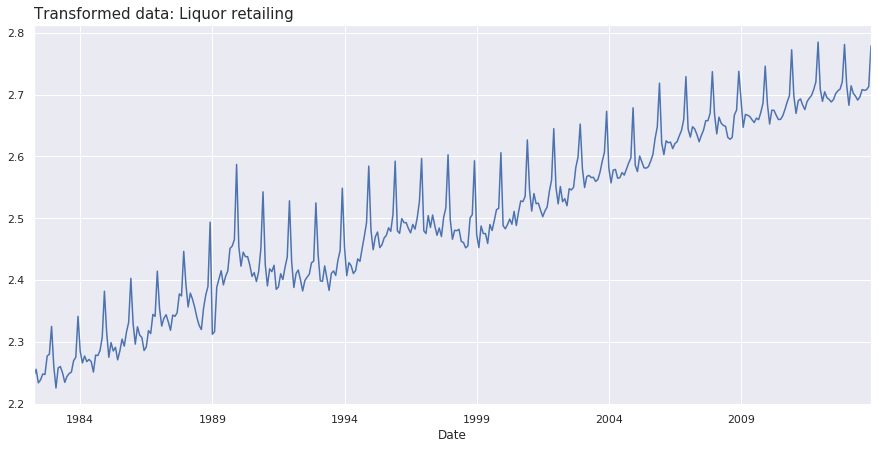

In [8]:
n = 1

dfn = df.iloc[:,n]
dfn = dfn.apply(box_cox,lam = -0.3) # transform data
title = df.columns[n]
_, ax = plt.subplots(figsize = (15,7))
dfn.plot(ax= ax)
plt.title('Transformed data: ' +title , fontsize = 15, loc = 'left');

In [9]:
# # Plot of forecast using transformed data
# methods = [avg_fc, naive_fc, drift_fc, seas_naive_fc]
# labels = ['avg','naive','drift','seasonal naive']
# _, ax = plt.subplots(figsize = (10,7))
# for i, meth in enumerate(methods):
#     res = dfn['2013'] - meth
#     ax.plot(res, label = labels[i])
# plt.legend()
# plt.title('Forecast Error', loc = 'left' ,fontsize = 20);

In [10]:
# Function to normalize datatime object to just year
def normalize(df):
    df.index = df.index.year
    return df

In [11]:
# group data by month
by_month = dict(list(dfn.groupby(dfn.index.month)))

# normalize datatime object to just year
by_month = {k:normalize(v) for k,v in by_month.items()}

# Create columns for each month
dff = pd.DataFrame([], index = by_month[1].index)
for k,g in by_month.items():
    g.name = k
    dff = pd.merge(dff,g, left_index = True, right_index = True)

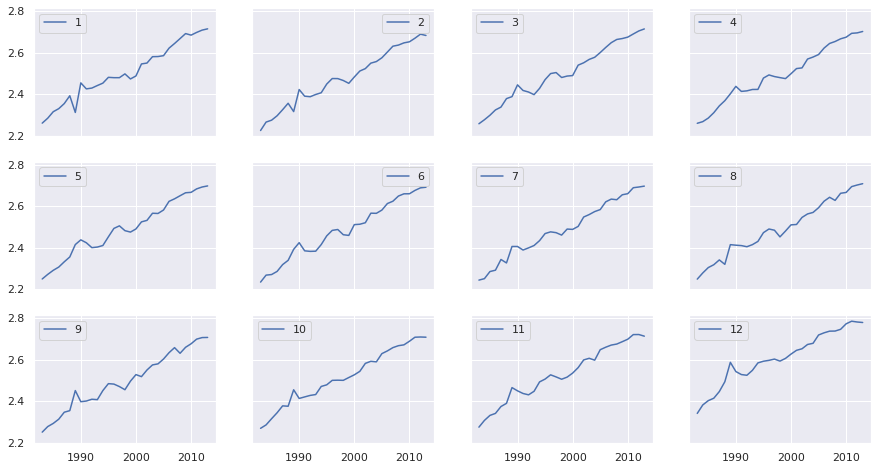

In [12]:
# plot of monthly data accros years
fig, axes = plt.subplots(nrows= 3, ncols = 4, figsize = (15,8), sharex  = True ,sharey = True)
axes = axes.ravel()
for i, ax in enumerate(axes):
    ax.plot(dff.index, dff.iloc[:,i].values, label = str(i+1))
    ax.legend()

In [13]:
def normalize_year(df):
    """Change index to years"""
    df.index = df.index.month
    return df

# group by years
by_year = dict(list(dfn.groupby(dfn.index.year)))

# Apply normalize_year to the index
by_year = {k:normalize_year(v) for k,v in by_year.items()}

# Stacking each year side  by side into a DataFrame 
dfff = pd.DataFrame([], index = range(1,13))
for k,g in by_year.items():
    g.name = k
    dfff = pd.merge(dfff,g, left_index = True, right_index = True, how = 'left')

dfff = dfff.fillna(0)

/home/isaac/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


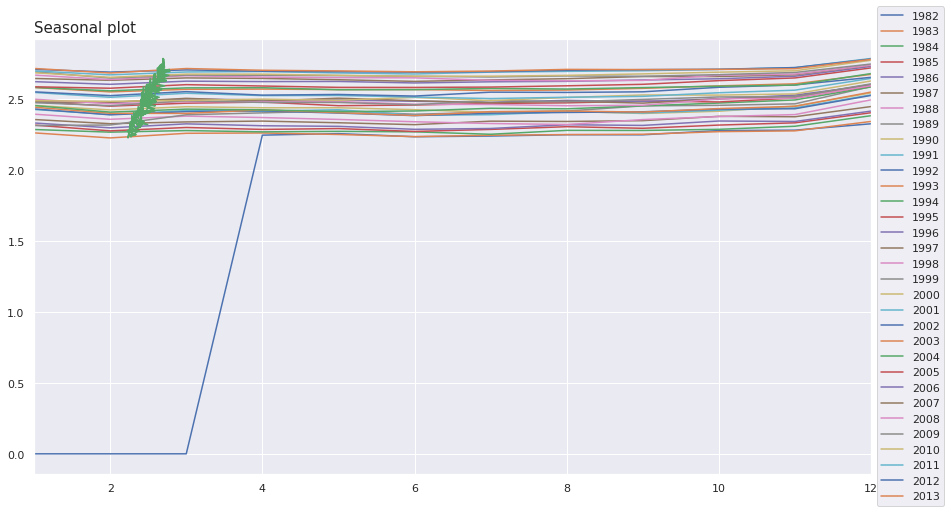

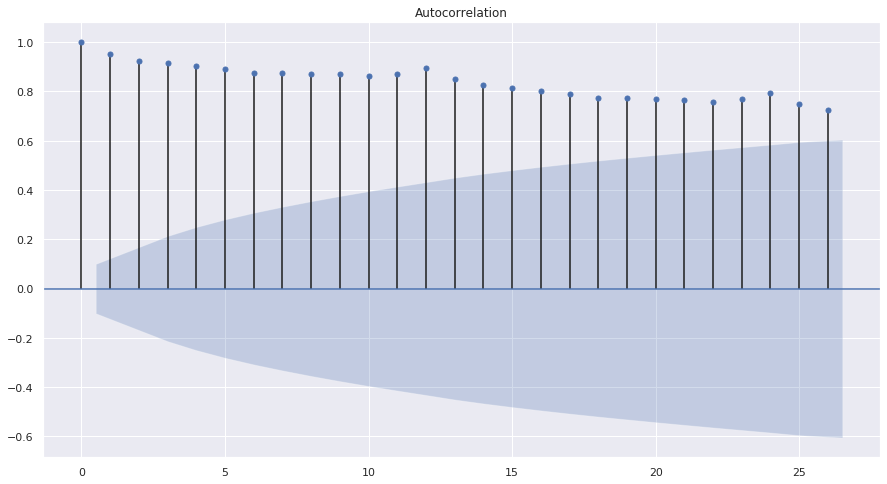

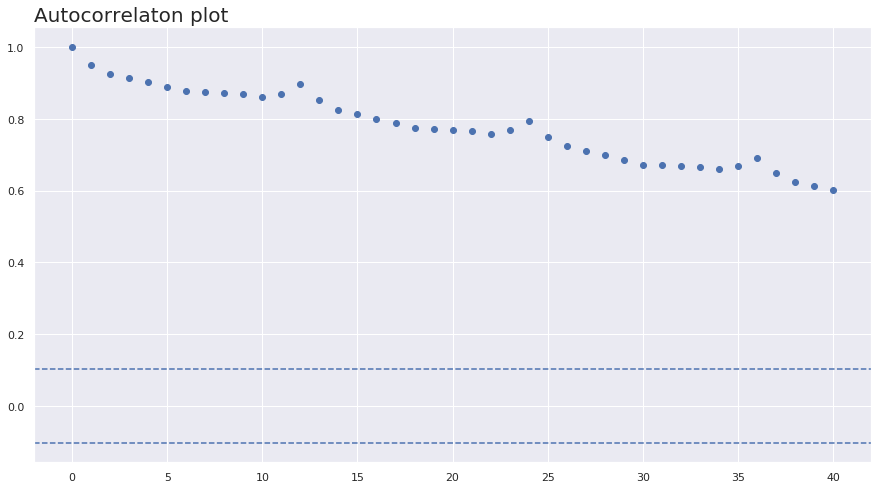

In [14]:
# Make a plot 
fig, ax = plt.subplots(figsize = (15,8))
dfff.plot(ax = ax)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('Seasonal plot', fontsize = 15, loc='left');

# lag plot
plt.plot(dfn.shift(-2).values, dfn.shift(2).values)

_, ax = plt.subplots(figsize = (15,8))
ax = plot_acf(dfn.values, ax = ax)

acf_val = acf(dfn.values)

n = df.shape[0]
err = 2/np.sqrt(n)
nlags = len(acf_val)
upper_bound = np.repeat(err, nlags)
lower_bound = np.repeat(-err, nlags)

_, ax = plt.subplots(figsize = (15,8))
ax.plot(acf_val, marker = 'o', linestyle = '')
ax.axhline(y = err, linestyle = '--')
ax.axhline(y = -err, linestyle = '--')
plt.title('Autocorrelaton plot', fontsize = 20, loc = 'left');

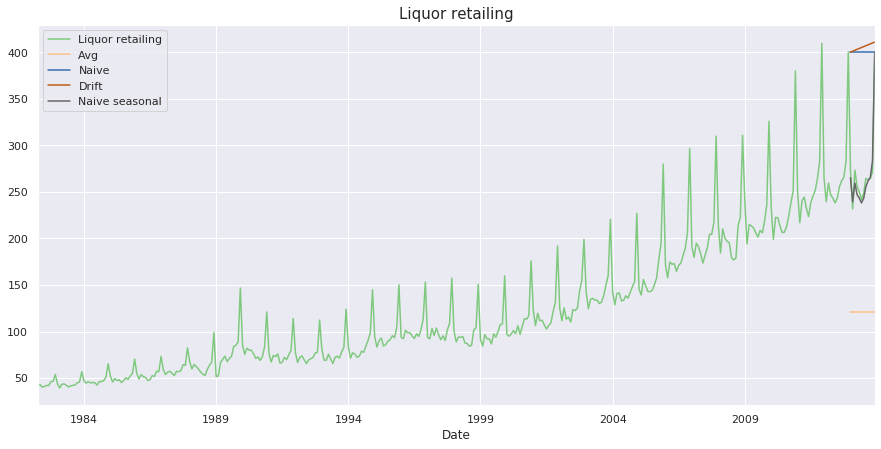

In [15]:
# plot time series
# plot of monthly forecast for year 2013
n = 1

dfn = df.iloc[:,n]
_, ax = plt.subplots(figsize = (15,7))
n = 1
# dfn.plot(ax= ax)

avg_fc = pd.Series(np.repeat(mean_forecast(dfn[:'2012']),12 ), index = dfn['2013'].index, name = 'Avg')
naive_fc = pd.Series(np.repeat(naive_forecast(dfn[:'2012']),12 ), index = dfn['2013'].index, name = 'Naive')
drift_fc = pd.Series([drift_forecast(dfn[:'2012'],i) for i in range(12)], index = dfn['2013'].index, name = 'Drift')
seas_naive_fc =  pd.Series(seasonal_naive(dfn[:'2012']), index = dfn['2013'].index, name = 'Naive seasonal')
t = pd.merge(dfn, avg_fc, left_index = True, right_index = True, how = 'left')
t = pd.merge(t, naive_fc, left_index = True, right_index = True, how = 'left')
t = pd.merge(t, drift_fc, left_index = True, right_index = True, how = 'left')
t = pd.merge(t, seas_naive_fc, left_index = True, right_index = True, how = 'left')
t.plot(ax = ax, colormap = matplotlib.cm.Accent)
plt.title(df.columns[n], fontsize = 15);


In [16]:
def avg_method(ts):
    val = ts.values
    n = ts.shape[0]
    data = np.repeat(np.nan,n)
    out = pd.Series(data, index = ts.index)
    out[0] = ts[0]
    for i in range(1,n):
        out[i] = np.mean(ts[:i+1])
    return out

def drift_method(ts, h= 1):
   
    T = ts.shape[0]
    data = np.repeat(np.nan,T)
    out = pd.Series(data, index = ts.index)
    out[0] = ts[0]
    for i in range(1,T):
        subseries = ts[:i+1]
        out[i] = drift_forecast(subseries, h)
    return out


In [17]:
def residual_plots(err, name = ''):
    """
    Function takes error time series and time series name.
    inputs:
            err: pandas.Series -> a time series
            name: string -> name of time series object
    outputs:
            (ax1, ax2, ax3)
    """
    fig = plt.figure(figsize = (15, 10))
    grid = GridSpec(2,2)
    ax1 = fig.add_subplot(grid[0,:])
    ax2 = fig.add_subplot(grid[1,0])
    ax3 = fig.add_subplot(grid[1,1])
    ax1.plot(err)
    ax2.hist(err)
    plot_acf(err, ax = ax3)
    fig.suptitle('Residual plot: '+ name, fontsize = 15)
    return (ax1, ax2, ax3)

In [18]:
# training error/residuals
naive_res = (dfn[:'2012']  - dfn[:'2012'].shift(1)).fillna(0)
avg_res = dfn[:'2012'] - avg_method(dfn[:'2012'])
seas_naive_res = (dfn['1983':'2012']  - dfn['1983':'2012'].shift(12)).fillna(0)
drift_res = dfn[:'2012'] - drift_method(dfn[:'2012'])

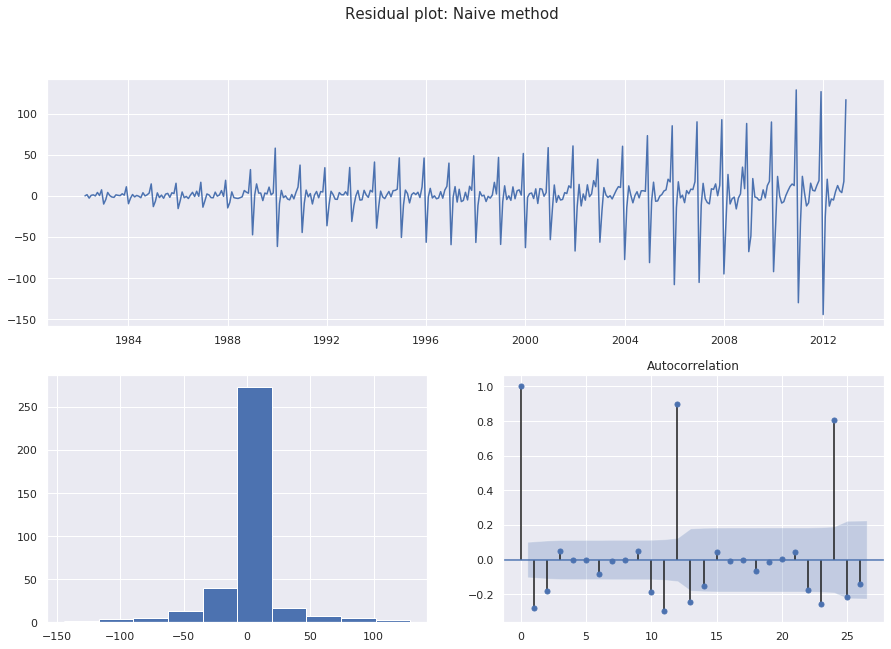

In [19]:
residual_plots(naive_res, 'Naive method');

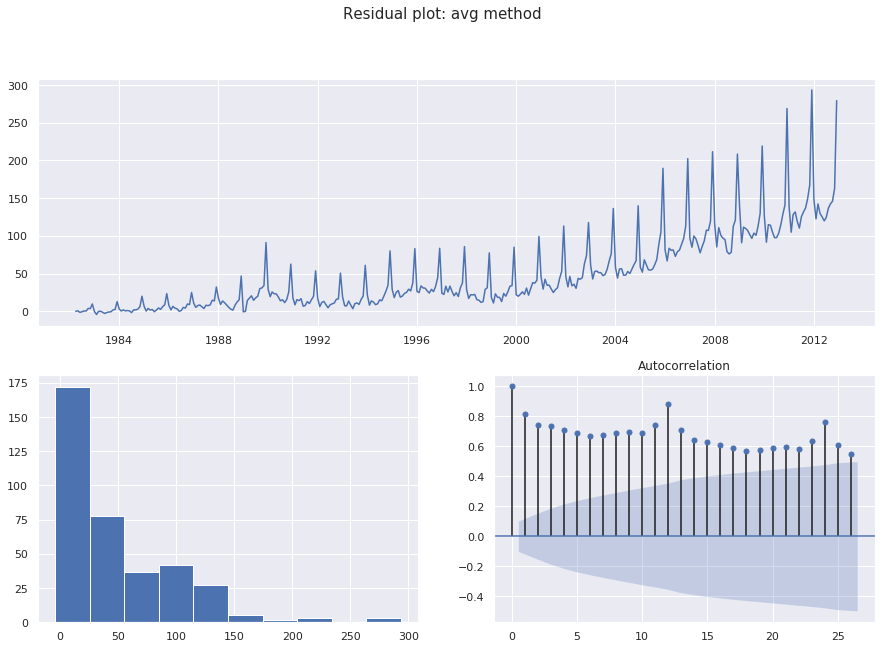

In [20]:
residual_plots(avg_res, 'avg method');

(<matplotlib.axes._subplots.AxesSubplot at 0x7fe5293eaa10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe5293baa50>)

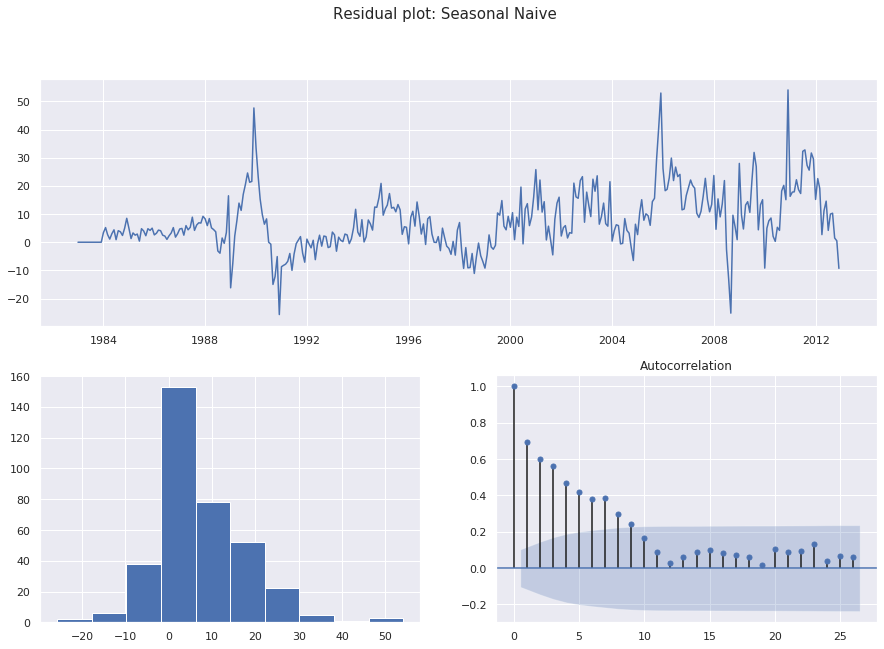

In [21]:
residual_plots(seas_naive_res,'Seasonal Naive')

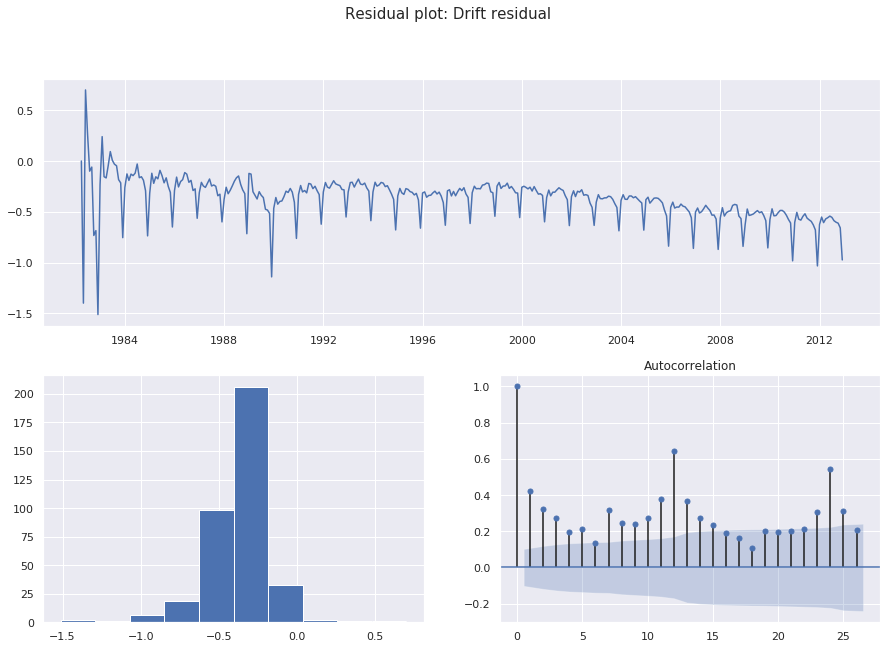

In [22]:
residual_plots(drift_res,'Drift residual');

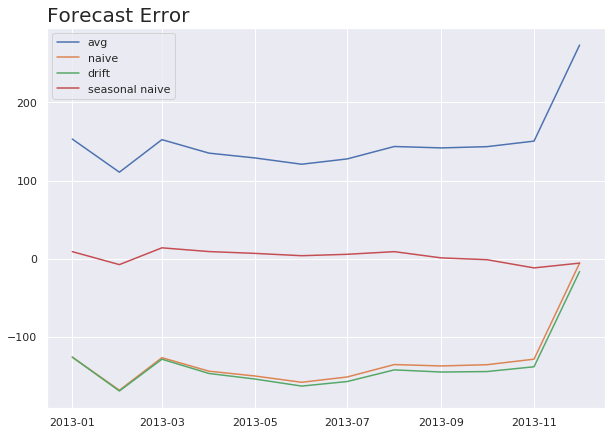

In [23]:
# Plot of forecast
methods = [avg_fc, naive_fc, drift_fc, seas_naive_fc]
labels = ['avg','naive','drift','seasonal naive']
_, ax = plt.subplots(figsize = (10,7))
for i, meth in enumerate(methods):
    res = dfn['2013'] - meth
    ax.plot(res, label = labels[i])
plt.legend()
plt.title('Forecast Error', loc = 'left' ,fontsize = 20);

In [24]:
# residuals
residuals = t['2013'].apply(lambda x: t['2013']['Liquor retailing'] - x).drop('Liquor retailing', axis = 1)
residuals.head(2)

,Avg,Naive,Drift,Naive seasonal
Date,,,,
2013-01-01,153.066938,-126.2,-126.200000,8.9
2013-02-01,110.666938,-168.6,-169.574457,-7.7


In [25]:
def report_residual_summary(res, ts):
    """
    Function computes model evaluation scores:
    1. Mean Absolute Error (MAE)
    2. Root Squared Mean Error  (RMSE)
    3. Mean Absolute Percentage Error (MAPE)
    for the given residual time series `res`
    
    inputs:
            res: pandas.Series object -> Residual time series
            ts: pandas.Series object -> Actual time series data
    output:
        DataFrame
    """
    MSE = res.apply(mae)
    MSE.name = 'mae'
    RMSE = res.apply(rmse)
    RMSE.name = 'rmse'
    MAPE = res.apply(mape,ts = ts )
    MAPE.name = 'mape'
    t = pd.merge(MSE,RMSE, left_index = True, right_index = True)
    return pd.merge(t,MAPE, left_index = True, right_index = True)

In [26]:
report_residual_summary(residuals, dfn['2013'])

,mae,rmse,mape
Avg,148.441938,153.667235,0.543442
Naive,130.825000,136.725238,0.510003
Drift,136.184511,141.413572,0.529476
Naive seasonal,7.016667,7.937254,0.026368


#  Exploring Models



## Regression model
Regressing `Supermarket and grocery stores` on `Liquor retailing`,
and `Other specialised food retailing` might show a sign of spurious regression.

In [27]:
mark_liq = df[:'2012'].iloc[:, :3]


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


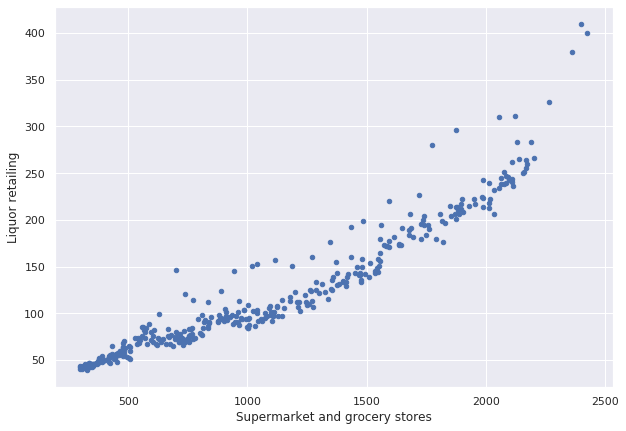

In [28]:
fig, ax = plt.subplots(figsize = (10,7))
mark_liq.plot(ax = ax ,
              kind = 'scatter', x ='Supermarket and grocery stores', y = 'Liquor retailing');

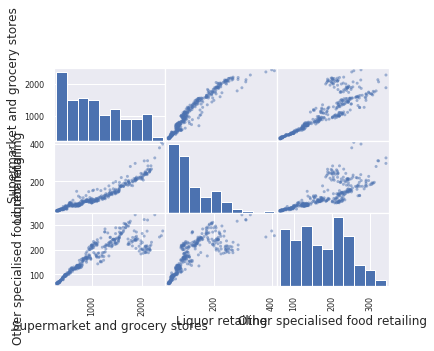

In [29]:
pd.plotting.scatter_matrix(mark_liq);

## Fitting Linear Model

In [30]:
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [31]:
x1 = mark_liq.iloc[:, 1].values
x2 = mark_liq.iloc[:, 2].values
X = np.column_stack([x1,x2])
X = sm.add_constant(X)
y = mark_liq.iloc[:, 0].values

## Transform variables
# lam = 0.5
# y = box_cox(y, lam)

model = sm.OLS(y,X)
result = model.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     2770.
Date:                Mon, 13 Jul 2020   Prob (F-statistic):          9.39e-222
Time:                        16:20:17   Log-Likelihood:                -2352.5
No. Observations:                 369   AIC:                             4711.
Df Residuals:                     366   BIC:                             4723.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -53.9445     20.260     -2.663      0.0

## Model evaluations

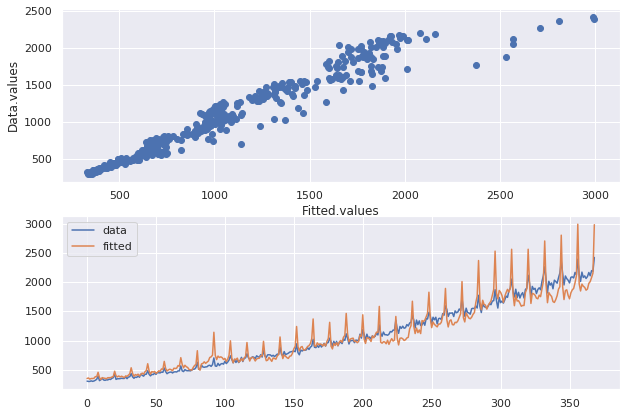

In [32]:
# Plot of fitted values vs actual target values
fitted = result.predict()
fig, (ax1,ax2) = plt.subplots(nrows = 2, figsize = (10,7))
ax1.scatter(fitted,y)
ax1.set_xlabel('Fitted.values')
ax1.set_ylabel('Data.values')
# plt.title('Accuracy of fitted values', loc = 'left', fontsize = 15)
ax2.plot(y, label= 'data')
ax2.plot(fitted, label = 'fitted')
ax2.legend()

In [33]:

residual = result.predict() - y

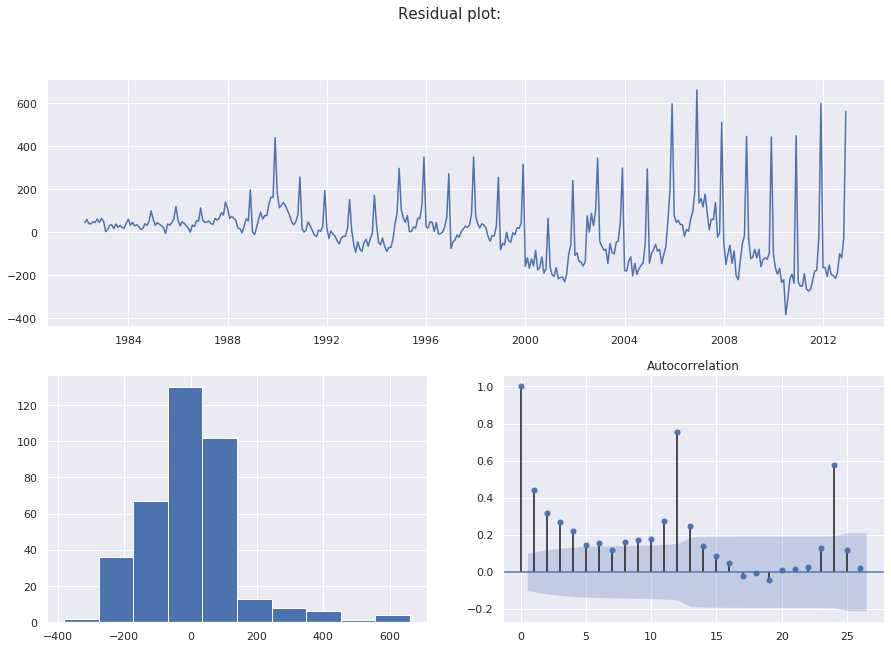

In [34]:
residual_plots(pd.Series(residual,index = df[:'2012'].index));

In [35]:
def residual_std_error(res, df):
    """
    Computes stardard deviation of residuals of time series regression
    input:
            res: residual array 
            df: number of estimated parameters.
    output: A number
    """
    return np.sqrt(np.sum(res**2)/(len(res) - df))

In [36]:
#residual_std_error(residual, 3) # 143.36992642620186
# prstd, iv_l, iv_u = wls_prediction_std(result)

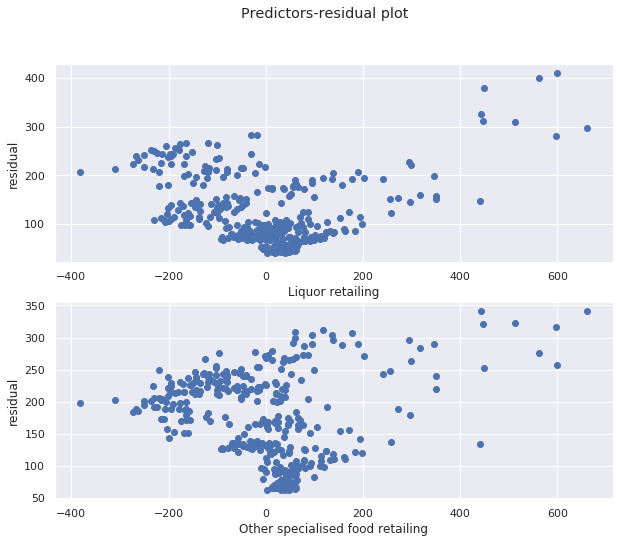

In [37]:
# Residual plot against predictors
fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (10,8))
ax1.scatter(residual, mark_liq.iloc[:,1].values)
ax1.set_xlabel(df.columns[1])
ax1.set_ylabel('residual')
ax2.scatter(residual, mark_liq.iloc[:,2].values)
ax2.set_xlabel(df.columns[2])
ax2.set_ylabel('residual')

plt.suptitle('Predictors-residual plot');


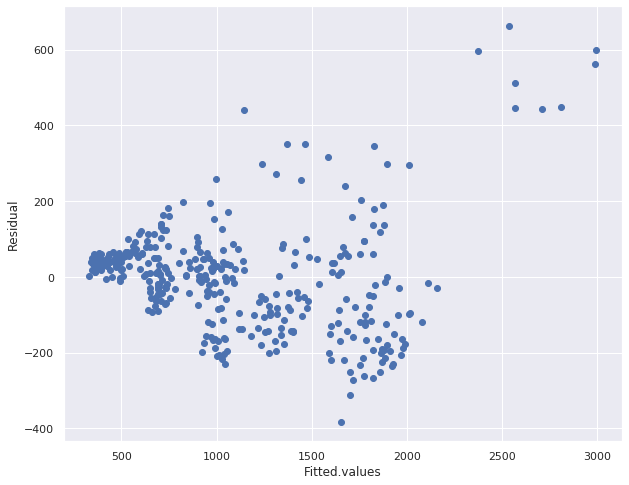

In [38]:
# Plot shows heteroscedasticity. The analysis needs to be repeated with a tranformation
# of the variables

fig, ax = plt.subplots(figsize = (10,8))
ax.scatter(fitted, residual)
ax.set_xlabel('Fitted.values')
ax.set_ylabel('Residual');

## Time series decomposition

In [39]:
dfn = df.iloc[:,1]


In [40]:
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose

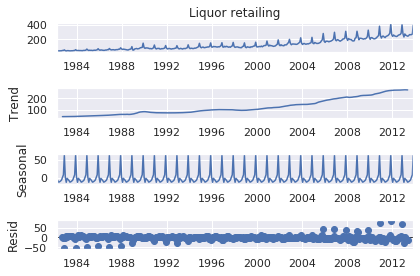

In [41]:
# Classical additive decomposition
res_additive = seasonal_decompose(dfn, model = 'additive')

ax = res_additive.plot()

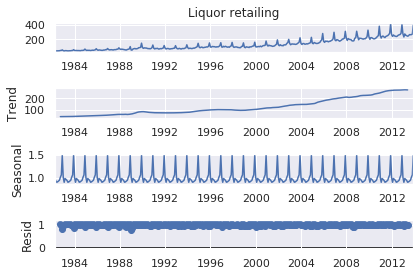

In [42]:
# classical multiplicative decomposition
res_mult = seasonal_decompose(dfn, model = 'multiplicative')
ax = res_mult.plot()

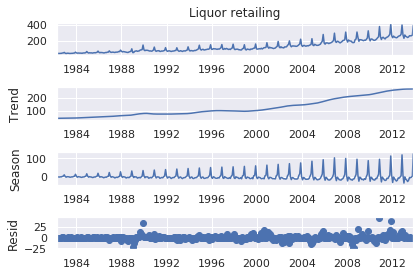

In [43]:
# Seasonal and trend decomposition using loess
## without transformation
res = STL(dfn, seasonal = 7, robust = True).fit()
ax = res.plot()

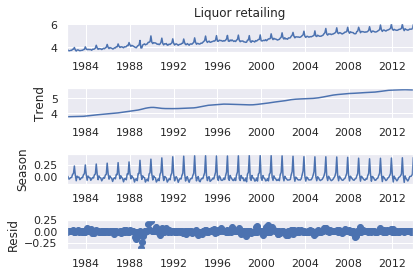

In [44]:
# Seasonal and trend decomposition using loess
## with transformation
res = STL(box_cox(dfn,0), seasonal = 7, robust = True).fit()
ax = res.plot()

In [45]:
# # 2 x 12 moving average
# ma24 = pd.concat([dfn,
#         dfn.rolling(window = 12, center = True).mean().rolling(2, center = True).mean()], axis = 1)
# ma24.columns = ['liquor', '12-MA']
# ma24.plot();

In [46]:
# Strength of trend: max(0 , Var(R)/Var(R + T))
np.max(1 - np.var(res.resid)/np.var((res.observed -  res.seasonal)))

0.9941361987708497

In [47]:
# strength of season: max(0, Var(R)/Var(S + T))
np.max(1- np.var(res.resid)/np.var((res.observed -  res.trend)))

0.9091390192610652

# Exponential smoothing

In [48]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [49]:
data = [446.6565,  454.4733,  455.663 ,  423.6322,  456.2713,  440.5881, 425.3325,  485.1494,  506.0482,  526.792 ,  514.2689,  494.211 ]
index= pd.date_range(start='1996', end='2008', freq='A')
oildata = pd.Series(data, index)

data = [17.5534,  21.86  ,  23.8866,  26.9293,  26.8885,  28.8314, 30.0751,  30.9535,  30.1857,  31.5797,  32.5776,  33.4774, 39.0216,  41.3864,  41.5966]
index= pd.date_range(start='1990', end='2005', freq='A')
air = pd.Series(data, index)

data = [263.9177,  268.3072,  260.6626,  266.6394,  277.5158,  283.834 , 290.309 ,  292.4742,  300.8307,  309.2867,  318.3311,  329.3724, 338.884 ,  339.2441,  328.6006,  314.2554,  314.4597,  321.4138, 329.7893,  346.3852,  352.2979,  348.3705,  417.5629,  417.1236, 417.7495,  412.2339,  411.9468,  394.6971,  401.4993,  408.2705, 414.2428]
index= pd.date_range(start='1970', end='2001', freq='A')
livestock2 = pd.Series(data, index)

data = [407.9979 ,  403.4608,  413.8249,  428.105 ,  445.3387,  452.9942, 455.7402]
index= pd.date_range(start='2001', end='2008', freq='A')
livestock3 = pd.Series(data, index)

data = [41.7275,  24.0418,  32.3281,  37.3287,  46.2132,  29.3463, 36.4829,  42.9777,  48.9015,  31.1802,  37.7179,  40.4202, 51.2069,  31.8872,  40.9783,  43.7725,  55.5586,  33.8509, 42.0764,  45.6423,  59.7668,  35.1919,  44.3197,  47.9137]
index= pd.date_range(start='2005', end='2010-Q4', freq='QS-OCT')
aust = pd.Series(data, index)

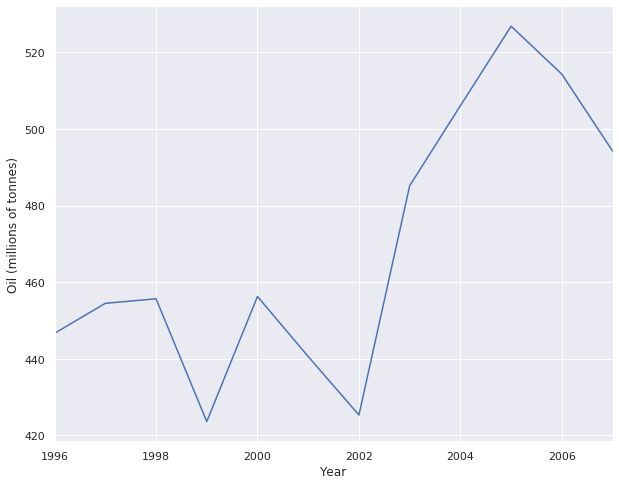

Figure 7.1: Oil production in Saudi Arabia from 1996 to 2007.


In [50]:
fig, ax = plt.subplots(figsize = (10,8))
oildata.plot(ax = ax)
ax.set_xlabel("Year")
ax.set_ylabel("Oil (millions of tonnes)")
plt.show()
print("Figure 7.1: Oil production in Saudi Arabia from 1996 to 2007.")

In [51]:
ses = SimpleExpSmoothing(oildata).fit()

Figure 7.1: Oil production in Saudi Arabia from 1996 to 2007.


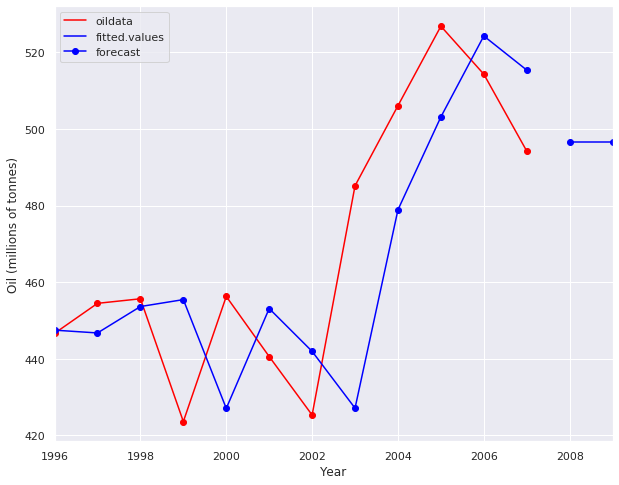

In [52]:
fig, ax = plt.subplots(figsize = (10,8))
oildata.name = 'oildata'
oildata.plot(ax = ax, color = 'red', marker = 'o', legend = True)
ax.set_xlabel("Year")
ax.set_ylabel("Oil (millions of tonnes)")
print("Figure 7.1: Oil production in Saudi Arabia from 1996 to 2007.")
fitted = ses.fittedvalues
fitted.name = 'fitted.values'
fitted.plot(ax = ax, color = 'blue', marker = 'o', legend = True)
fcast = ses.forecast(2)
fcast.name = 'forecast'
fcast.plot(ax = ax , color = 'blue', marker = 'o', legend = True)

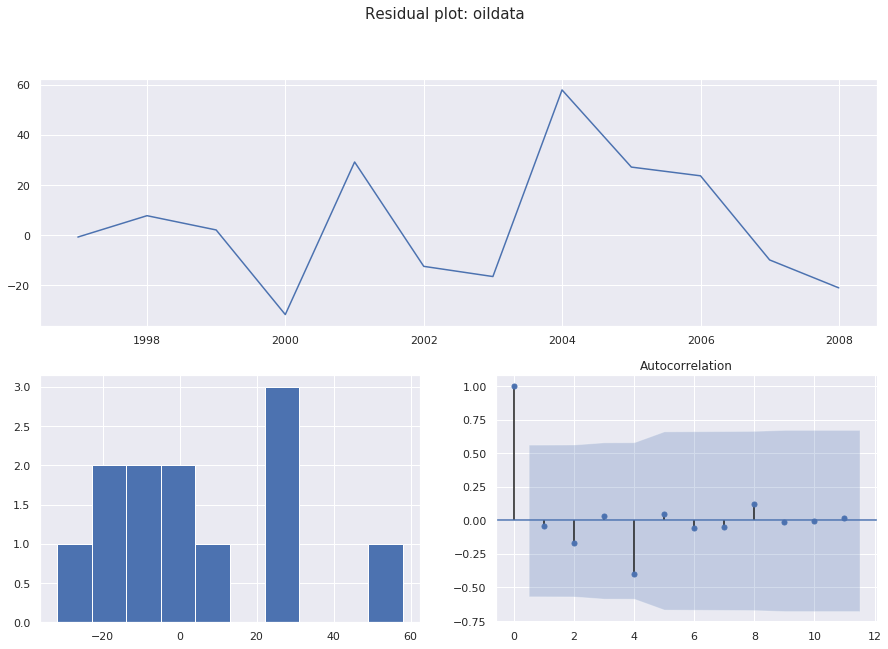

In [53]:
residual_plots(ses.resid, 'oildata');

/home/isaac/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


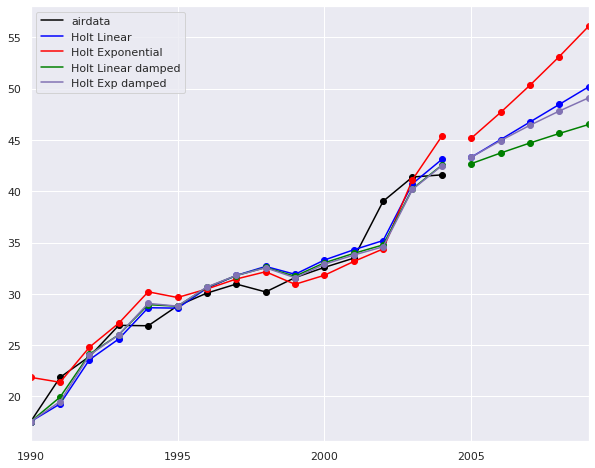

In [54]:
# Holt linear, Holt's exponential, Holt's damped *
fig, ax = plt.subplots(figsize = (10,8))
air.name = 'airdata'
air.plot(marker = 'o', color = 'black', legend = True)
mod1 = Holt(air).fit()
mod2 = Holt(air, exponential=True).fit()
mod3 = Holt(air,damped=True).fit()
mod4 = Holt(air, damped = True, exponential=True).fit()

fcast1 = mod1.forecast(5); fcast1.name = 'Holt Linear'
fcast2 = mod2.forecast(5); fcast2.name = 'Holt Exponential'
fcast3 = mod3.forecast(5); fcast3.name = 'Holt Linear damped'
fcast4 = mod4.forecast(5); fcast4.name = 'Holt Exp damped'

fcast1.plot(marker = 'o', color = 'blue', legend = True)
fcast2.plot(marker = 'o', color = 'red', legend = True)
fcast3.plot(marker = 'o', color = 'green', legend = True)
fcast4.plot(marker = 'o', color = 'm', legend = True)


mod1.fittedvalues.plot(marker = 'o', color = 'blue')
mod2.fittedvalues.plot(marker = 'o', color = 'red')
mod3.fittedvalues.plot(marker = 'o', color = 'green')
mod4.fittedvalues.plot(marker = 'o', color = 'm');


In [55]:
pd.DataFrame({
    'Holt_linear': mod1.params,
    'Holt_exponential':mod2.params,
    'Holt_damped': mod3.params,
    'Holt_exp_damped': mod4.params
})

,Holt_linear,Holt_exponential,Holt_damped,Holt_exp_damped
smoothing_level,1,0.684211,1,1
smoothing_slope,0,0.684211,0,0
smoothing_seasonal,NaN,NaN,NaN,NaN
damping_slope,NaN,NaN,0.946006,0.89885
initial_level,15.836,17.5534,15.0376,15.613
initial_slope,1.71737,1.24534,2.65944,1.2508
initial_seasons,[],[],[],[]
use_boxcox,False,False,False,False
lamda,None,None,None,None
remove_bias,False,False,False,False


In [56]:
print('Holt Linear seems to look promising amongst the exponential smoothing methods')
pd.DataFrame({
    'Holt_linear': {'aic': mod1.aic, 'aicc':mod1.aicc, 'bic': mod1.bic},
    'Holt_exponential':{'aic': mod2.aic, 'aicc':mod2.aicc, 'bic': mod2.bic},
    'Holt_damped': {'aic': mod3.aic, 'aicc':mod3.aicc, 'bic': mod3.bic},
    'Holt_exp_damped': {'aic': mod4.aic, 'aicc':mod4.aicc, 'bic': mod4.bic}
})


Holt Linear seems to look promising amongst the exponential smoothing methods


,Holt_linear,Holt_exponential,Holt_damped,Holt_exp_damped
aic,21.715752,31.636493,23.216934,24.667393
aicc,32.215752,42.136493,39.216934,40.667393
bic,24.547953,34.468693,26.757185,28.207644


## Holt-Winters' Seasonal method

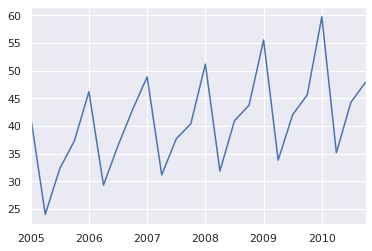

In [57]:
## Data in the section is the international visitor night in Australia (millions)
## source: https://otexts.com/fpp2/ets-forecasting.html
aust.plot()

In [58]:
mod1 = ExponentialSmoothing(aust, trend = 'add', seasonal = 'add',seasonal_periods=4)\
.fit(use_boxcox=True)
mod2 = ExponentialSmoothing(aust, trend = 'add', seasonal = 'mul', seasonal_periods = 4)\
.fit(use_boxcox=True)
mod3 = ExponentialSmoothing(aust, trend = 'add', seasonal = 'add', seasonal_periods = 4,
                           damped=True).fit(use_boxcox = True)
mod4 = mod3 = ExponentialSmoothing(aust, trend = 'add', seasonal = 'mul', seasonal_periods = 4,
                           damped=True).fit(use_boxcox = True)


/home/isaac/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/isaac/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/isaac/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


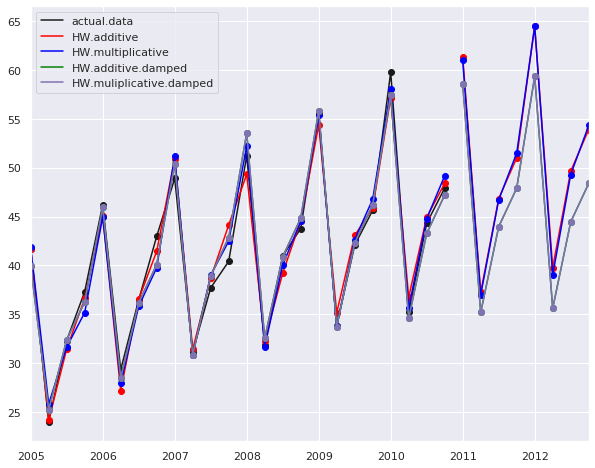

In [59]:
fig, ax = plt.subplots(figsize = (10, 8))
fit1 = mod1.fittedvalues; fit1.name = 'HW.additive'
fit2 = mod2.fittedvalues; fit2.name = 'HW.multiplicative'
fit3 = mod3.fittedvalues; fit3.name = 'HW.additive.damped'
fit4  = mod4.fittedvalues; fit4.name = 'HW.muliplicative.damped'

fcast1 = mod1.forecast(8)
fcast2 = mod2.forecast(8)
fcast3 = mod3.forecast(8)
fcast4 = mod4.forecast(8)
fitcast = [
    (fit1, fcast1),
    (fit2, fcast2),
    (fit3, fcast3),
    (fit4, fcast4)
]
colors = ['red', 'blue','green','m']
aust.name = 'actual.data'
aust.plot(ax = ax, legend = True, color = 'k', marker = 'o')
for i,(fit,fcast) in enumerate(fitcast):
    fit.plot(ax = ax , legend = True, color =  colors[i], marker = 'o')
    fcast.plot(ax = ax , color =  colors[i], marker = 'o')

In [60]:
pd.DataFrame({
    'HW.additive': {'aic': mod1.aic, 'aicc':mod1.aicc, 'bic': mod1.bic},
    'HW.multiplicative':{'aic': mod2.aic, 'aicc':mod2.aicc, 'bic': mod2.bic},
    'HW.additive.damped': {'aic': mod3.aic, 'aicc':mod3.aicc, 'bic': mod3.bic},
    'HW.multiplicative.damped': {'aic': mod4.aic, 'aicc':mod4.aicc, 'bic': mod4.bic}
})
print('Looks like Mupliticative model is relatively better compared to other models')
print('Multiplicative was expected because seasonality is proportional to the level of series')

Looks like Mupliticative model is relatively better compared to other models
Multiplicative was expected because seasonality is proportional to the level of series


In [61]:
## Using bootstrap method to generate prediction interval
## Assume forecast errors are distributed as residuals
resid = mod2.resid

# Sample 100 residuals and add it to forecasts
paths = []
for f in fcast2:
    paths.append(resid.sample(100, replace = True) + f)
forecast_resid = pd.DataFrame(np.column_stack(paths))

In [62]:
forecast_resid.head()

,0,1,2,3,4,5,6,7
0,59.705711,37.936636,45.450865,51.692908,64.533368,37.756194,48.723634,53.059242
1,59.170456,35.197406,47.381995,51.698253,63.489461,42.225069,48.030359,54.978030
2,61.176891,34.718917,47.995785,51.560318,63.164226,37.880816,49.949147,57.528117
3,60.509896,38.277580,46.247437,50.516411,65.125908,38.886391,47.495105,54.189439
4,61.909686,38.277580,48.124003,50.191176,66.595174,38.273251,49.949147,54.978030


There is not no discernable trend in error time series
There is no significant autocorrelation.
In conclusion: Multiplicative data di quit well. I looks like there is a slightheteroscedasticity in the residual but it is not significant
Histogram of residual plot indicates non-normality thus normal distribution may notbe appropriate for estimating prediction interval.


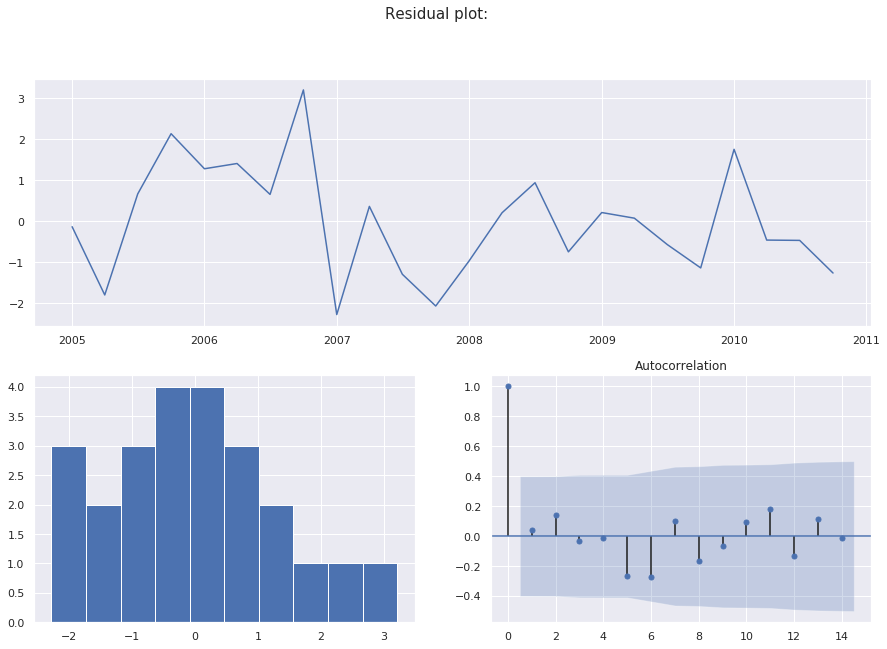

In [63]:
residual_plots(resid);
print('There is not no discernable trend in error time series')
print('There is no significant autocorrelation.')
print('In conclusion: Multiplicative data di quit well. I looks like there is a slight\
heteroscedasticity in the residual but it is not significant')
print('Histogram of residual plot indicates non-normality thus normal distribution may not\
be appropriate for estimating prediction interval.')

In [64]:
def get_quantile(x, interval = 95):
    """
    x is a distribution of  h-step forecast. 
    input: x is pandas.Series object
    output:  Estimate of 95 or 80  confidence interval. 
    """
    if interval == 95:
        return pd.Series([x.quantile(0.025),x.quantile(0.975)],index = ['lq', 'uq'])
    elif interval == 80:
        return pd.Series([x.quantile(0.1),x.quantile(0.9)],index = ['lq', 'uq'])
    else:
        raise ValueError('interval must be either 95 or 80')

Dark blue region is 80 percent confidence interval
Light blue region is 95 percent confidence interval


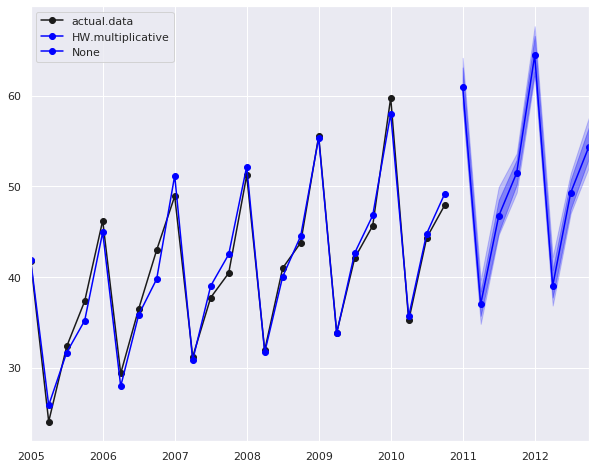

In [65]:
# Compute quantiles for forecast distributions

qtile95 = forecast_resid.apply(get_quantile)
qtile80 = forecast_resid.apply(get_quantile, interval = 80)

fig, ax = plt.subplots(figsize = (10, 8))
aust.plot(ax = ax , legend = True, marker = 'o', color = 'k') # plot main data
ax = fit2.plot(ax = ax, legend = True, marker = 'o', color = 'blue') # plot fitted data
ax = fcast2.plot(ax = ax, marker = 'o', color = 'blue') # plot forecast
x = fcast2.index
# 95 percent C.I
l95 = qtile95.iloc[0,:].values
u95 = qtile95.iloc[1,:].values
ax.fill_between(x, l95, u95, color = 'blue', alpha  = 0.2)
# 80 percent C.I
l80 = qtile80.iloc[0,:].values
u80 = qtile80.iloc[1,:].values
ax.fill_between(x, l80, u80, color = 'blue', alpha  = 0.3)
ax.legend(loc=0);
print('Dark blue region is 80 percent confidence interval')
print('Light blue region is 95 percent confidence interval')

In [67]:
# ToDo: Apply Exponential smoothing model to  australian `Liquor retailing` data

# ARIMA models